### Crawling daily market data of KOSPI200 from Naver Finance.
Naver Finance: Finance section of the most popular website, whose name is Naver, in Korea.

#### 1. Import modules
- datetime: for changing objects to data type.


- urlopen in urllib.request: for getting source codes from a website.


- BeautifulSoup in bs4: it includes functions which help us can get specific part of data from the source codes.

In [1]:
import datetime as dt                
from urllib.request import urlopen   
from bs4 import BeautifulSoup

#### 2. Function 'date_format'
- functions for changing date data in Naver(website) as a date type data.<br><br><br>

##### funtions used below
- str(): change a object to a string type data.
- replace(): replace a element assigned as a first parameter to a element assigned as a second parameter.
- split(): split a string object and change it into a list. A parameter will be a seperator.
- dt.date(): first parameter: year, second parameter: month, third parameter: day.

In [8]:
def date_format(d):                     
    
    d = str(d).replace('-', '.')        
    yyyy = int(d.split('.')[0])         
    mm = int(d.split('.')[1])           
    dd = int(d.split('.')[2])       
    
    this_date = dt.date(yyyy, mm, dd) 
    return this_date

# Example
date_format('2020-5-11')

datetime.date(2020, 5, 11)

#### 3. Function 'historical_index_naver'
parameters<br>
- code name of the company
- starting date
- ending date
- page number shows end price of the stock
- assign 0 to last_page, because we do not know what is the last page.<br>
  last page is always changed because data is accumulated, so we have to find the last page<br>
  using codes.

In [57]:
def historical_index_naver(index_cd, start_date='', end_date='', page_n=1, last_page=0):
    
    # 파라미터로는 
    # index_cd (코드명. ex, 코스피, 코스피200 ..) 
    # start_date(원하는 기간의 시작일), end_date(종료일) 날짜를 문자열로 넣는다
    # page_n =1   항상 1페이지 부터 시작한다
    # last_page = 0  마지막페이지는 아직 몇인지 모르니 우선 0으로 놓는다
    
    if start_date:                                   # 만약 start_date를 정의해줬으면
        start_date = date_format(start_date)        # start_date를 위에서 만든 date_format함수로 원하는 형태로 바꿔주자
    else:
        start_date = dt.date.today()                # 만약 start_date를 정의해주지 않았다면 오늘 날짜로 정의
    
    if end_date:                                    # 만약 end_date를 정의해줬으면
        end_date = date_format(end_date)            # end_date를 위에서 만든 date_format함수로 원하는 형태로 바꿔주자
    else:
        end_date = dt.date.today()                  # 만약 end_date를 정의해주지 않았다면 오늘 날짜로 정의
        
        
    # 코스피200 일별시세 url 소스코드를 가져오기
        
    naver_index = r'https://finance.naver.com/sise/sise_index_day.nhn?code=' + index_cd + r'&page=' + str(page_n)
    source = urlopen(naver_index).read()
    source = BeautifulSoup(source, 'lxml')
    
    dates = source.find_all('td', class_ = 'date')          # 날짜수집
    prices = source.find_all('td', class_ = 'number_1')     # 지수수집
    
    
    
    for n in range(len(dates)): # 특정페이지에서 6개의 날짜가 출력됨. 6개의 날짜데이터 모두 코르블록 실행
        
        if dates[n].text.split('.')[0].isdigit():  # 만약 n번째 페이지의 날짜데이터의 첫번째 인덱스가 숫자라면 코드블록 실행
                                                   # (날짜데이터가 맞는지 확인하는?)
        
            # 날짜 처리를 처리
            
            this_date = dates[n].text              # n번째 태그에서 날짜인 text만 가져오기
            this_date = date_format(this_date)     # 위에서 정의해준 date_format함수로 원하는 형태로 날짜 만들어주기
            
            # 만약 this_date가 정의해줄 end_date보다 작거나 같고 start_date보다 크거나 같으면 코드블록 실행
            # 즉 end_date와 start_date 사이의 날짜들에 대해서만 코드 실행
            
            if this_date <= end_date and this_date >=start_date:  
                
            # 종가 처리
                this_close = prices[n*4].text            #종가는 ('td', class_='number_1')을 가진 소스들의 5번째에 옴
                                                         # 그러므르 인덱스는 4의 배수(4*n)이 필요

                this_close = this_close.replace(',', '')  # 숫자의 천 단위마다 있는 ,를 빼준다.
                this_close = float(this_close)            # 그후 실수타입으로 바꿔줌

            # 딕셔너리에 저장
                historical_prices[this_date] = this_close # 날짜:종가 형태가 나올 수 있도록 dict에 저장
            
            elif this_date < start_date:                  
                return historical_prices
            
    # 페이지 내비게이션 / 일별시세의 마지막 페이지가 몇인지 알기위함
    if last_page == 0:                          
        last_page = source.find('td', class_ = 'pgRR').find('a')['href']
        last_page = last_page.split('&')[1]
        last_page = int(last_page.split('=')[1])
    
    # 다음페이지 호출
    if page_n <= last_page: #페이지가 마지막 페이지까지 돌 수 있도록 하기
        page_n += 1        #페이지는 하나씩 올라가야함
        historical_index_naver(index_cd, start_date, end_date, page_n, last_page)
        
        # 만약 마지막 페이지가 5라고 하면
        # 우리가 정의해준 함수 historical_index_naver는
        # historical_index_naver(index_cd, start_date, end_date, 1, 5)
        # historical_index_naver(index_cd, start_date, end_date, 2, 5) ... 이런식으로 page_n가 5가 될때까지 실행
    
    return historical_prices # 반환은 dict 타입인 historical_prices로 한다

index_cd = 'KPI200'
historical_prices = dict()
historical_index_naver(index_cd, '2010-1-1')
historical_prices

{datetime.date(2020, 5, 25): 262.76,
 datetime.date(2020, 5, 22): 259.62,
 datetime.date(2020, 5, 21): 263.74,
 datetime.date(2020, 5, 20): 262.72,
 datetime.date(2020, 5, 19): 261.79,
 datetime.date(2020, 5, 18): 255.44,
 datetime.date(2020, 5, 15): 253.79,
 datetime.date(2020, 5, 14): 253.65,
 datetime.date(2020, 5, 13): 255.85,
 datetime.date(2020, 5, 12): 253.37,
 datetime.date(2020, 5, 11): 254.95,
 datetime.date(2020, 5, 8): 256.62,
 datetime.date(2020, 5, 7): 254.46,
 datetime.date(2020, 5, 6): 255.0,
 datetime.date(2020, 5, 4): 250.6,
 datetime.date(2020, 4, 29): 258.15,
 datetime.date(2020, 4, 28): 256.39,
 datetime.date(2020, 4, 27): 254.84,
 datetime.date(2020, 4, 24): 250.28,
 datetime.date(2020, 4, 23): 253.74,
 datetime.date(2020, 4, 22): 251.88,
 datetime.date(2020, 4, 21): 249.4,
 datetime.date(2020, 4, 20): 252.14,
 datetime.date(2020, 4, 17): 255.02,
 datetime.date(2020, 4, 16): 247.1,
 datetime.date(2020, 4, 14): 247.45,
 datetime.date(2020, 4, 13): 243.4,
 datetime.

In [62]:
import pandas as pd
c = pd.DataFrame.from_dict(historical_prices, orient = 'index')
c.sort_index(inplace = True)
c.columns = ['종가']
c.tail(10)

,종가
2020-05-12,253.37
2020-05-13,255.85
2020-05-14,253.65
2020-05-15,253.79
2020-05-18,255.44
2020-05-19,261.79
2020-05-20,262.72
2020-05-21,263.74
2020-05-22,259.62
2020-05-25,262.76


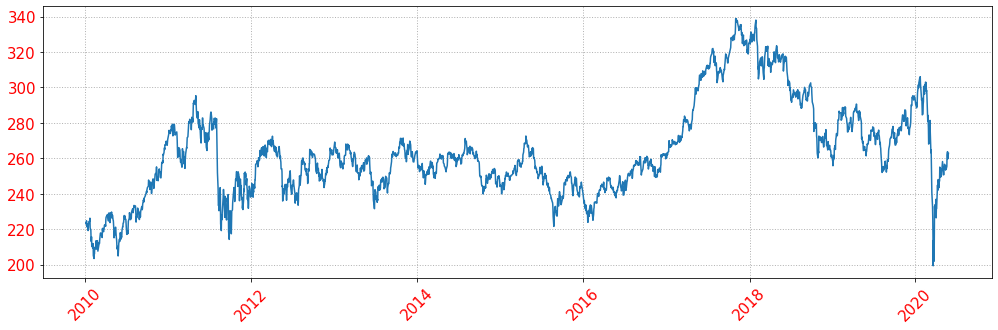

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize = (17, 5))
plt.plot(c)
plt.xticks(color = 'r', fontsize = 15, rotation = 45)
plt.yticks(color = 'r', fontsize = 15)
plt.grid(True, color = '0.7', linestyle = ':', linewidth = 1)